In [1]:
import h5py, os, pystan
import numpy as np
from os.path import dirname
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
import os, pystan
import _pickle as pickle
from pandas import DataFrame

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

In [3]:
PATH_NAME = '/Users/kierstenmarr/Desktop/TDLR'

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'TLDR.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [5]:
from numba import njit

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

# TDLR written similar to Sam's MB python code

In [37]:
class TDLR(object):
    
    def __init__(self, beta_1, beta_2, alpha_com, alpha_rare):
        
        ## Define parameters.
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.alpha_com = alpha_com
        self.alpha_rare = alpha_rare
        
        ## Initialize Q-values.
        self.Q = None
        self.MB = None
        
    def train(self, drifts, reset=False):

        ## Initialize Q-values.
        self.Q = np.ones((2,2)) * 0.5
        self.MB = np.ones(2) * 0.5
            
        ## Preallocate space.
        n_trials = drifts.shape[0]
        Y1, Y2, S2, t, r = np.zeros((5,n_trials), dtype=int)
            
        for i in range(n_trials):
            
            ## Stage 1: Compute choice likelihood.
            theta = inv_logit( self.beta_1 * (self.MB[1] - self.MB[0]) )
            
            ## Stage 1: Simulate choice.
            Y1[i] = np.random.binomial(1,theta)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S2[i] = np.where(t[i], 1-Y1[i], Y1[i])
                        
            ## Stage 2: Compute choice likelihood.
            theta = inv_logit( self.beta_2 * (self.Q[S2[i],1] - self.Q[S2[i],0]) )
            
            ## Stage 2: Simulate choice.
            Y2[i] = np.random.binomial(1,theta)
            
            ## Stage 2: Observe outcome.
            #r[i] = R[i,S2[i]-1,Y2[i]]
            r[i] = np.random.binomial(1, drifts[i, S2[i], Y2[i]])
            
            # Check for transition type and assign LR
            if (Y1[i] == t[i]):
                alpha = self.alpha_com
            else:
                alpha = self.alpha_rare
            
            ## Stage 2: Update Q-values.
            self.Q[S2[i],Y2[i]] += alpha * ( r[i] - self.Q[S2[i],Y2[i]] )
            
            ## Update Stage 1 Q values
            self.MB[0] = 0.7*np.max(self.Q[0]) + 0.3*np.max(self.Q[1])
            self.MB[1] = 0.3*np.max(self.Q[0]) + 0.7*np.max(self.Q[1])
            
        return Y1, t, S2, Y2, r

In [38]:
from tqdm import tqdm

In [39]:
import seaborn as sns
sns.set('notebook', style='white', font='sans-serif', font_scale=1.33)

100%|██████████| 201/201 [00:02<00:00, 82.17it/s]


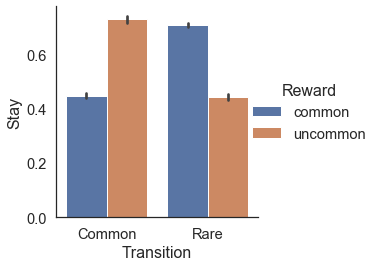

In [40]:
np.random.seed(47404)

## Define reward parameters.
drifts = read_csv('drifts.txt', header=None).values.reshape(-1,2,2)
T = drifts.shape[0]

data = []
for _ in tqdm(range(T)):
    
    ## Simulate outcomes.
    #R = np.random.binomial(1, [[0.7,0.3],[0.3,0.7]], (200,2,2))
    
    ## Initialize agent.
    agent = TDLR(beta_1 = 7, beta_2 = 7, alpha_com = 0.8, alpha_rare=0.2)

    ## Train agent.
    Y1, t, S2, Y2, r = agent.train(drifts)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y1[:-1] == Y1[1:]

    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

# TDLR w/ drifts

In [33]:
class TDLR2(object):
    
    def __init__(self, beta_1, beta_2, alpha_com, alpha_rare):
        
        ## Define parameters.
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.alpha_com = alpha_com
        self.alpha_rare = alpha_rare
        
        ## Initialize Q-values.
        self.Q = None
        
    def train(self, drifts, reset=False):

        ## Initialize Q-values.
        if self.Q is None or reset:
            self.Q = 0.5 * np.ones((3,2))
            
        ## Preallocate space.
        n_trials = drifts.shape[0]
        Y1, Y2, S2, t, r = np.zeros((5,n_trials), dtype=int)
            
        for i in range(n_trials):
            
            ## Stage 1: Compute choice likelihood.
            theta = inv_logit( self.beta_1 * np.diff(self.Q[0]) )
            
            ## Stage 1: Simulate choice.
            Y1[i] = np.random.binomial(1,theta)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S = np.where(t[i], Y1[i], 1-Y1[i]) + 1
                        
            ## Stage 2: Compute choice likelihood.
            theta = inv_logit( self.beta_2 * np.diff(self.Q[S]) )
            
            ## Stage 2: Simulate choice.
            Y2[i] = np.random.binomial(1,theta)
            
            ## Stage 2: Observe outcome.
            #r[i] = R[i,S-1,Y2[i]]
            r[i] = np.random.binomial(1, drifts[i, S-1, Y2[i]])
            
            # Check for transition type and assign LR
            if (Y1[i] == t[i]):
                alpha = self.alpha_com
            else:
                alpha = self.alpha_rare
            
            ## Stage 2: Update Q-values.
            self.Q[S,Y2[i]] += alpha * ( r[i] - self.Q[S,Y2[i]] )
            
            ## Stage 1: Re-compute Q-values.
            #self.Q[0] = T @ self.Q[1:].max(axis=1)
            self.Q[0,0] = 0.7*max(self.Q[1]) + 0.3*max(self.Q[2])
            self.Q[0,1] = 0.3*max(self.Q[1]) + 0.7*max(self.Q[2])
            
        return Y1, Y2, t, r

100%|██████████| 201/201 [00:05<00:00, 37.68it/s]


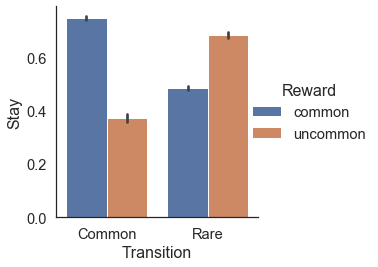

In [34]:
np.random.seed(47404)

## Define reward parameters.
drifts = read_csv('drifts.txt', header=None).values.reshape(-1,2,2)
T = drifts.shape[0]

data = []
for _ in tqdm(range(T)):
    
    ## Simulate outcomes.
    #R = np.random.binomial(1, [[0.7,0.3],[0.3,0.7]], (200,2,2))
    
    ## Initialize agent.
    agent = TDLR2(beta_1 = 7, beta_2 = 7, alpha_com = 0.8, alpha_rare=0.2)

    ## Train agent.
    Y1, Y2, t, r = agent.train(drifts)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y1[:-1] == Y1[1:]

    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

# TDLR with no drifts, just generated Rs

In [35]:

class TDLR3(object):
    
    def __init__(self, beta_1, beta_2, alpha_com, alpha_rare):
        
        ## Define parameters.
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.alpha_com = alpha_com
        self.alpha_rare = alpha_rare
        
        ## Initialize Q-values.
        self.Q = None
        
    def train(self, R, reset=False):
        
        ## Error-catching: rewards.
        R = np.array(R)

        ## Initialize Q-values.
        if self.Q is None or reset:
            self.Q = 0.5 * np.ones((3,2))
            
        ## Preallocate space.
        n_trials = R.shape[0]
        Y = np.zeros((n_trials, 2), dtype=int)
        t = np.zeros(n_trials, dtype=int)
        r = np.zeros(n_trials)
            
        for i in range(n_trials):
            
            ## Stage 1: Re-compute Q-values.
            #self.Q[0] = T @ self.Q[1:].max(axis=1)
            self.Q[0,0] = 0.7*max(self.Q[1]) + 0.3*max(self.Q[2])
            self.Q[0,1] = 0.3*max(self.Q[1]) + 0.7*max(self.Q[2])
            
            ## Stage 1: Compute choice likelihood.
            theta = inv_logit( self.beta_1 * np.diff(self.Q[0]) )
            
            ## Stage 1: Simulate choice.
            Y[i,0] = np.random.binomial(1,theta)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S = np.where(t[i], Y[i,0], 1-Y[i,0]) + 1
                        
            ## Stage 2: Compute choice likelihood.
            theta = inv_logit( self.beta_2 * np.diff(self.Q[S]) )
            
            ## Stage 2: Simulate choice.
            Y[i,1] = np.random.binomial(1,theta)
            
            ## Stage 2: Observe outcome.
            r[i] = R[i,S-1,Y[i,1]]
            
            # Check for transition type and assign LR
            if (Y[i,0] == t[i]):
                alpha = self.alpha_com
            else:
                alpha = self.alpha_rare
            
            ## Stage 2: Update Q-values.
            self.Q[S,Y[i,1]] += alpha * ( r[i] - self.Q[S,Y[i,1]] )
            
        return Y, t, r

100%|██████████| 200/200 [00:04<00:00, 41.14it/s]


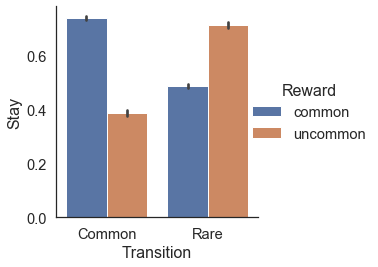

In [36]:
np.random.seed(47404)

data = []
for _ in tqdm(range(200)):
    
    ## Simulate outcomes.
    R = np.random.binomial(1, [[0.5,0.5],[0.5,0.5]], (200,2,2))
    
    ## Initialize agent.
    agent = TDLR3(beta_1 = 7, beta_2 = 7, alpha_com = 0.9, alpha_rare=0.1)

    ## Train agent.
    Y, t, r = agent.train(R)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y[:-1,0] == Y[1:,0]

    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

# Ignore this for now (Stan running stuff)

In [23]:
R = r.astype(int)
R

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1])

In [24]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=200, Y=Y, O=t, reward=R)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [25]:
StanModel.optimizing(data=dd)

OrderedDict([('beta1_pr', array(-3.14587621)),
             ('beta2_pr', array(-1.14063306)),
             ('etaC_pr', array(-0.00151574)),
             ('etaR_pr', array(-0.41723372)),
             ('beta1', array(0.01458716)),
             ('beta2', array(2.54168817)),
             ('etaC', array(0.49939461)),
             ('etaR', array(0.33811682))])

In [26]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=47404)

In [27]:
print(StanFit)

Inference for Stan model: anon_model_ecdf07b0721fd5faf712f069570cd157.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1_pr  -3.33  5.9e-3   0.33  -4.09   -3.5  -3.27  -3.09  -2.83   3103    1.0
beta2_pr   -1.2  3.3e-3   0.18  -1.53  -1.32   -1.2  -1.08  -0.83   2974    1.0
etaC_pr    0.18    0.01   0.62  -0.82  -0.26   0.11   0.54    1.6   3083    1.0
etaR_pr    -0.4  5.9e-3   0.36  -1.11  -0.64  -0.41  -0.18   0.32   3782    1.0
beta1      0.01  1.5e-4   0.01 2.3e-4 3.6e-3 9.0e-3   0.02   0.04   5930    1.0
beta2      2.39    0.01   0.72   1.27   1.89    2.3   2.81   4.07   2920    1.0
etaC       0.56  3.5e-3    0.2   0.21    0.4   0.54   0.71   0.95   3258    1.0
etaR       0.35  2.0e-3   0.13   0.13   0.26   0.34   0.43   0.62   3827    1.0
lp__     -268.0    0.03   1.62 -272.0 -268.7 -267.6 -266.8 -266.0   2597    1.0

Samples we